In [1]:
import gdown
import zipfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [2]:
zip_file_url = 'https://drive.google.com/uc?id=1YsQ8qT69UKG3hqfO-Ab550PJobnVJApV'
zip_file_name = gdown.download(zip_file_url, quiet=True)

zip_folder_name = Path(zip_file_name).stem

zip_file_manager = zipfile.ZipFile(zip_file_name, 'r')
zip_file_manager.extractall()

In [3]:
TRAIN_IMAGES_FOLDER = f'{zip_folder_name}/training/'
VALID_IMAGES_FOLDER = f'{zip_folder_name}/validation/'
BATCH_SIZE = 32

In [4]:
train_generator = ImageDataGenerator(rotation_range=90, brightness_range=[0.1, 0.7], width_shift_range=0.5, 
                                     height_shift_range=0.5, horizontal_flip=True, vertical_flip=True,
                                     preprocessing_function=preprocess_input)

valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
traingen = train_generator.flow_from_directory(TRAIN_IMAGES_FOLDER, target_size=(224, 224), class_mode='categorical',
                                               subset='training', batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

validgen = valid_generator.flow_from_directory(VALID_IMAGES_FOLDER, target_size=(224, 224), class_mode='categorical',
                                             batch_size=1, shuffle=False, seed=42)

Found 201 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [6]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compila un modelo integrado a las capas pre entrenadas de VGG16
    
    input_shape: tupla - shape de las imágenes input (width, height, channels)
    n_classes: entero - número de clases en la capa output
    optimizer: string - optimizador usado para entrenar. Por defecto en rmsprop
    fine_tune: entero - número de capas preentrenadas que vamos a desfrezear. 
                Si lo seteamos en 0, todas las capas preentrenadas serán freezeadas.
    """
    
    # Cargamos las capas de la CNN con los pesos preentrenados con Imagenet
    # include_top=False es para excluir la parte fully connected de la red
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Definimos cuántas capas vamos a freezear en el entrenamiento
    # Las capas en la base convolucional se switchean de entrenable a no entrenable
    # según el número fine_tune
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Creamos un nuevo "top" model (fully connected)
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1028, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Juntamos modelo convolucional con fully connected en un objeto Model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compilamos
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Entrenamiento

En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que avanza, las funciones son cada vez más específicas para el conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para que funcionen con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

In [7]:
INPUT_SHAPE = (224, 224, 3)
CLASSES = 2
EPOCHS = 50
MAX_TRAINABLE_LAYERS = 4

In [ ]:
history = {}
accuracy = {}

n_steps = (traingen.samples//BATCH_SIZE) + 1
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')

for trainable_layer in range(MAX_TRAINABLE_LAYERS):
  
  optimizer = Adam(learning_rate=0.001) if trainable_layer == 0 else Adam(learning_rate=0.0001)
  
  tl_checkpoint = ModelCheckpoint(filepath=f'{trainable_layer}.weights.best.hdf5',
                                  save_best_only=True, verbose=False)
  
  vgg_model = create_model(INPUT_SHAPE, CLASSES, optimizer, fine_tune=trainable_layer)
  
  history[trainable_layer] = vgg_model.fit(traingen, batch_size=BATCH_SIZE, epochs=EPOCHS,
                              steps_per_epoch=n_steps, validation_data=validgen,
                              callbacks=[early_stop, tl_checkpoint], verbose=False)
  
  vgg_model.load_weights(f'{trainable_layer}.weights.best.hdf5')
  vgg_predict_proba = vgg_model.predict(validgen)
  vgg_predict_classes = np.argmax(vgg_predict_proba, axis=1)

  accuracy[trainable_layer] = accuracy_score(validgen.classes, vgg_predict_classes)

58900480/58889256 [==============================] - 1s 0us/step


# Resultados

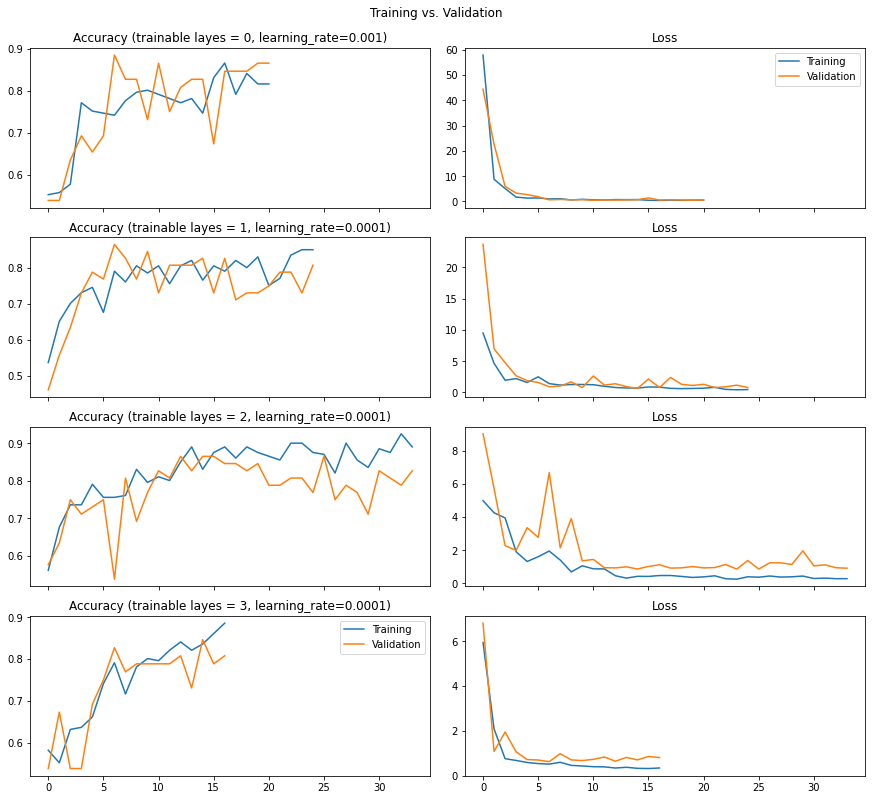

In [ ]:
fig, axs = plt.subplots(MAX_TRAINABLE_LAYERS, 2, figsize=(12,11), sharex=True,
                        constrained_layout=True)

fig.suptitle('Training vs. Validation')

for i in range(MAX_TRAINABLE_LAYERS):
  acc = history[i].history['accuracy']
  val_acc = history[i].history['val_accuracy']

  loss = history[i].history['loss']
  val_loss = history[i].history['val_loss']

  axs[i][0].plot(acc, label='Training')
  axs[i][0].plot(val_acc, label='Validation')
  
  axs[i][1].plot(loss, label='Training')
  axs[i][1].plot(val_loss, label='Validation')
  
  axs[i][0].set_title(f'Accuracy (trainable layes = {i}, learning_rate={0.001 if i == 0 else 0.0001})')
  axs[i][1].set_title(f'Loss')

  if i == MAX_TRAINABLE_LAYERS-1:
    axs[i][0].legend(loc='best')

  if i == 0:    
    axs[i][1].legend(loc='best')

plt.show()

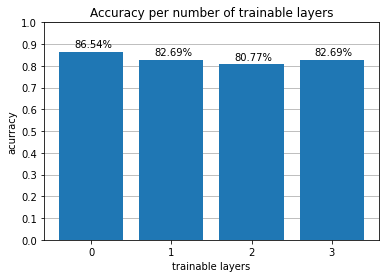

In [ ]:
plt.title('Accuracy per number of trainable layers')
plt.grid(axis = 'y', zorder=0)
plt.bar(*zip(*accuracy.items()), zorder=3)
plt.xlabel('trainable layers')
plt.ylabel('accuracy')
plt.xticks([*accuracy])
plt.yticks(np.arange(0.0, 1.1, 0.1))

for index, value in enumerate([*accuracy.values()]):
    plt.text(index-0.21, value + 0.02, f'{value:.2%}')

plt.show()

# Anexo

In [10]:
def image_data_generator_to_numpy(image_data_generator):
  data = image_data_generator.next()
  X = data[0]
  y = data[1]

  for i in range(image_data_generator.n - 1):
    data = image_data_generator.next()
    X = np.concatenate((X, data[0]), axis=0)
    y = np.concatenate((y, data[1]), axis=0) 

  return (X, y)

In [ ]:
X_train, y_train = image_data_generator_to_numpy(traingen)

In [ ]:
X_test, y_test = image_data_generator_to_numpy(validgen)

In [ ]:
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

In [ ]:
train_pred = conv_base.predict(X_train)
valid_pred = conv_base.predict(X_test)

In [ ]:
top_model = Sequential()
top_model.add(Flatten(name="flatten", input_shape=train_pred.shape[1:]))
top_model.add(Dense(4096, activation='relu'))
top_model.add(Dense(1028, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(CLASSES, activation='softmax'))
 
optimizer = Adam(learning_rate=0.001)

top_model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
n_steps = (traingen.samples//BATCH_SIZE) + 1
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
tl_checkpoint = ModelCheckpoint(filepath='0.weights.best.hdf5',
                                  save_best_only=True, verbose=False)

In [ ]:
history = top_model.fit(x=train_pred, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                              steps_per_epoch=n_steps, validation_data=(valid_pred, y_test),
                              callbacks=[early_stop, tl_checkpoint], verbose=False)

In [ ]:
top_model.load_weights('0.weights.best.hdf5')
vgg_predict_proba = top_model.predict(valid_pred)
vgg_predict_classes = np.argmax(vgg_predict_proba, axis=1)

In [ ]:
accuracy_score(validgen.classes, vgg_predict_classes)